<a href="https://colab.research.google.com/github/NicoleLia/Model-Adv/blob/main/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import BertTokenizer
from collections import defaultdict

In [5]:
!7z x /content/data/Flickr8k.zip -o/content/data/Flickr8k


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/data/                        1 file, 1112971163 bytes (1062 MiB)

Extracting archive: /content/data/Flickr8k.zip
 50% 4096 Open              --
Path = /content/data/Flickr8k.zip
Type = zip
Physical Size = 1112971163

  0%      3% 325 - Images/1350811702_2ce7cfd0c5.jpg                                             7% 608 - Images/1572286502_64e5c4b920.jpg                                            10% 864 - Images/2052953131_30834196fb.jpg                           

In [6]:
# initial
def load_data(captions_file, img_dir):
    df = pd.read_csv(captions_file)
    df['image'] = df['image'].apply(lambda x: os.path.join(img_dir, x))

    transform = Compose([
        Resize((224, 224)),
        ToTensor()
    ])

    xs = []
    ys = []

    for idx, row in df.iterrows():
        image = Image.open(row['image']).convert('RGB')
        caption = row['caption']

        image = transform(image)

        xs.append(image)
        ys.append(caption)

    return xs, ys

img_dir = '/content/data/Flickr8k/Images'
captions_file = '/content/data/Flickr8k/captions.txt'
xs, ys = load_data(captions_file, img_dir)
print("Loaded {} images and captions".format(len(xs)))

Loaded 40455 images and captions


In [7]:
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab('<pad>'))
    return images, captions.float()

In [8]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<unk>')
        self.add_word('<pad>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

vocab = Vocab()

In [9]:
# create instance
from torch.utils.data import Dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys, vocab):
        self.xs = xs
        self.ys = [torch.tensor([vocab(word) for word in y.split()], dtype=torch.long) for y in ys]
        self.vocab = vocab

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index]

dataset = Dataset(xs, ys, vocab)
print("Dataset length:", len(dataset))
x, y = dataset[0]
print("First item shape:", x.shape, "Caption:", y)

Dataset length: 40455
First item shape: torch.Size([3, 224, 224]) Caption: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab('<pad>'))
    return images, captions

loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

for images, captions in loader:
    print(images.shape, captions)
    break

torch.Size([32, 3, 224, 224]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0

In [11]:
import torch.nn as nn
from torchvision.models import resnet50

class VLM(nn.Module):
    def __init__(self, vocab_size):
        super(VLM, self).__init__()
        resnet = resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_img = nn.Linear(2048, 512)  # 图像特征到嵌入维度

        self.embed = nn.Embedding(vocab_size, 512)  # 字幕嵌入层
        self.transformer = nn.Transformer(
            d_model=512,
            nhead=8,
            num_encoder_layers=3,
            num_decoder_layers=3
        )
        self.output_fc = nn.Linear(512, vocab_size)  # 输出层

    def forward(self, images, captions):
        img_features = self.resnet_features(images)
        img_features = self.avgpool(img_features)
        img_features = torch.flatten(img_features, 1)
        img_features = self.fc_img(img_features)

        caption_features = self.embed(captions)

        # 扩展图像特征维度以匹配字幕特征
        img_features = img_features.unsqueeze(1).expand(-1, captions.size(1), -1)
        caption_features = caption_features.transpose(0, 1)  # [seq_len, batch_size, embed_size]
        caption_features = caption_features.transpose(0, 1)  # 转换为 [batch_size, seq_len, embed_size]


        transformer_output = self.transformer(img_features, caption_features)
        output = self.output_fc(transformer_output)

        return output

In [12]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [13]:
def adversarial_training(model, device, train_loader, optimizer, criterion, epsilon):
    model.train()
    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)

        outputs = model(images, captions)
        loss = criterion(outputs, captions)

        optimizer.zero_grad()
        loss.backward()
        data_grad = images.grad.data

        perturbed_data = fgsm_attack(images, epsilon, data_grad)

        outputs_perturbed = model(perturbed_data, captions)
        loss_perturbed = criterion(outputs_perturbed, captions)

        optimizer.zero_grad()
        loss_perturbed.backward()
        optimizer.step()

In [18]:
import matplotlib.pyplot as plt

In [31]:
def train(model, device, train_loader, optimizer, criterion, epochs, scheduler, print_every=50, save_path='/content/model/model1'):
    model.train()
    all_losses = []  # 记录所有损失以便绘图
    best_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0
        for i, (images, captions) in enumerate(train_loader):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            outputs = outputs.view(-1, outputs.size(-1))
            captions = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, captions)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if (i + 1) % print_every == 0:  # 每处理50个批次打印一次
                current_loss = total_loss / print_every
                all_losses.append(current_loss)  # 将当前计算的平均损失添加到列表
                print(f'Epoch {epoch+1}, Batch {i+1}, Partial Loss: {current_loss:.4f}')
                total_loss = 0  # 重置部分损失计数器

        scheduler.step()  # 更新学习率

        # 打印每个epoch的平均损失
        epoch_loss = sum(all_losses[-len(train_loader)//print_every:]) / (len(train_loader)//print_every)
        print(f'Epoch {epoch+1}, Total Loss: {epoch_loss:.4f}')

        if epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(model.state_dict(), save_path)
          print(f"Model improved and saved to {save_path}")

    # 绘制损失图
    plt.figure(figsize=(12, 6))
    plt.plot(all_losses, marker='o', linestyle='-', color='b')
    plt.title('Model Loss During Training')
    plt.xlabel('Number of Batches Processed')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [32]:
def load_and_test(model, device, test_loader, criterion, model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in test_loader:
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1])
            outputs = outputs.view(-1, outputs.size(-1))
            captions = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, captions)
            total_loss += loss.item()
    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')


In [33]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VLM(len(vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

Epoch 1, Batch 50, Partial Loss: 0.3681
Epoch 1, Batch 100, Partial Loss: 0.1409
Epoch 1, Batch 150, Partial Loss: 0.1377
Epoch 1, Batch 200, Partial Loss: 0.1367
Epoch 1, Batch 250, Partial Loss: 0.1384
Epoch 1, Batch 300, Partial Loss: 0.1386
Epoch 1, Batch 350, Partial Loss: 0.1387
Epoch 1, Batch 400, Partial Loss: 0.1370
Epoch 1, Batch 450, Partial Loss: 0.1364
Epoch 1, Batch 500, Partial Loss: 0.1355
Epoch 1, Batch 550, Partial Loss: 0.1386
Epoch 1, Batch 600, Partial Loss: 0.1377
Epoch 1, Batch 650, Partial Loss: 0.1407
Epoch 1, Batch 700, Partial Loss: 0.1355
Epoch 1, Batch 750, Partial Loss: 0.1399
Epoch 1, Batch 800, Partial Loss: 0.1347
Epoch 1, Batch 850, Partial Loss: 0.1388
Epoch 1, Batch 900, Partial Loss: 0.1333
Epoch 1, Batch 950, Partial Loss: 0.1394
Epoch 1, Batch 1000, Partial Loss: 0.1401
Epoch 1, Batch 1050, Partial Loss: 0.1387
Epoch 1, Batch 1100, Partial Loss: 0.1399
Epoch 1, Batch 1150, Partial Loss: 0.1391
Epoch 1, Batch 1200, Partial Loss: 0.1371
Epoch 1, Bat

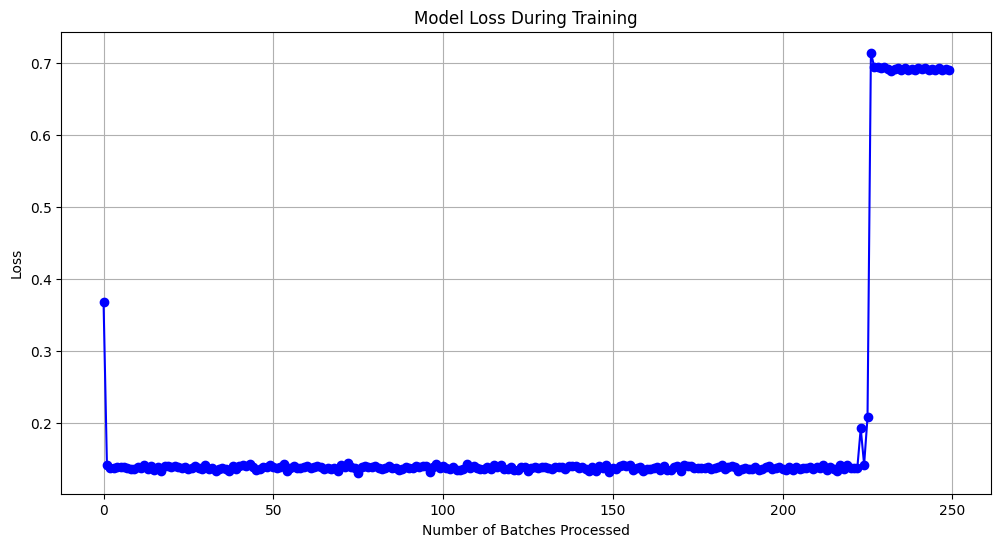

In [34]:
epochs = 10
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
train(model, device, loader, optimizer, criterion, epochs, scheduler, save_path='/content/model/model1')

In [ ]:
load_and_test(model, device, loader, criterion, '/content/model/model1')